In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from PIL import Image
from scipy import misc

In [123]:
std_dev = 25
gt_img = plt.imread('./camera_man.jpeg')[:,:,0]
noisy_img = gt_img+np.random.normal(0,std_dev,gt_img.shape)
noisy_img[noisy_img<0] = 0
noisy_img[noisy_img>255] = 255

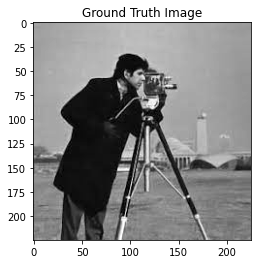

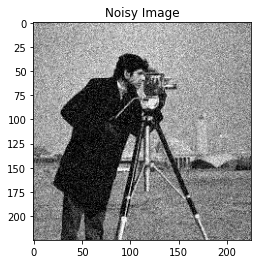

In [124]:
plt.imshow(gt_img,cmap='gray')
plt.title('Ground Truth Image')
plt.show()
plt.imshow(noisy_img,cmap='gray')
plt.title('Noisy Image')
plt.show()

In [5]:
print(np.min(noisy_img),np.max(noisy_img))

0.0 255.0


In [6]:
def dist(a,b):
    return np.sum(np.abs(a-b))/np.size(a)

In [71]:
def linear_point_ops(Img,P,L):
    res = np.zeros_like(Img,dtype=np.uint8)
    for i in range(Img.shape[0]):
        for j in range(Img.shape[1]):
            if ((Img[i,j]*P)+L)<=255 and ((Img[i,j]*P)+L)>=0:
                res[i,j] = int((Img[i,j]*P)+L)
            elif ((Img[i,j]*P)+L)>255:
                res[i,j] = 255
            else:
                res[i,j] = 0
    return res

def FSCS(Img):
    a = np.min(Img)
    b = np.max(Img)
    P = 255/(b-a)
    L = -(255*a)/(b-a)
    # print('P,L ',P,L)
    J = linear_point_ops(Img,P,L)
    return J

In [177]:
def wnnm(img, patch_r, delta, c, K, sigma, threshold):
    search_window_r = 3*patch_r

    iter = 3

    pad = 4*patch_r
    img_pad = np.pad(img,pad)

    X_hat = img

    for n in range(K):
        X_hat = np.pad(X_hat,pad)
        y = X_hat + delta*(img_pad-X_hat)
        pixel_contributions = np.ones_like(img_pad)

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                centre_patch = y[i+search_window_r:i+search_window_r+2*patch_r,j+search_window_r:j+search_window_r+2*patch_r]
                centre_patch_reshaped = np.reshape(centre_patch,(1,(2*patch_r)**2))
                dists = np.ones((2*search_window_r+1)**2)
                patches = np.zeros(((2*search_window_r+1)**2,(2*patch_r)**2))
                for k in range(2*search_window_r+1):
                    other_patch = y[i:i+2*pad,j+k:j+k+2*patch_r]
                    indices = np.reshape(np.arange((2*patch_r)**2),((1,(2*patch_r)**2)))+np.reshape((2*patch_r)*np.arange(other_patch.shape[0]-2*patch_r+1),(other_patch.shape[0]-2*patch_r+1,1))

                    other_patch = other_patch.flatten()
                    other_patch = np.reshape(other_patch[indices],(other_patch[indices].shape[0],(2*patch_r)**2))

                    dists[k*(2*search_window_r+1):(k+1)*(2*search_window_r+1)] = (np.sum(np.power(centre_patch_reshaped-other_patch,2),axis=1)/((2*patch_r)**2)).flatten()
                    patches[k*(2*search_window_r+1):(k+1)*(2*search_window_r+1),:] = other_patch
                

                idx = np.argsort(dists)
                Y = patches[idx[0:threshold],:].T
                U,S,V_T = linalg.svd(Y,full_matrices=False)

                singular_val_X_hat = np.sqrt(np.maximum(S**2-threshold*(sigma**2),0))


                for p in range(iter):
                    w = c*np.sqrt(threshold)/(singular_val_X_hat+1e-7)
                    singular_val_X_hat = np.maximum(singular_val_X_hat-w,0)

                Y_hat = U@np.diag(singular_val_X_hat)@V_T

                X_hat[i+search_window_r:i+search_window_r+2*patch_r,j+search_window_r:j+search_window_r+2*patch_r] = X_hat[i+search_window_r:i+search_window_r+2*patch_r,j+search_window_r:j+search_window_r+2*patch_r] + np.clip(Y_hat[:,0].reshape((2*patch_r,2*patch_r)),0,255)

                pixel_contributions[i+search_window_r:i+search_window_r+2*patch_r,j+search_window_r:j+search_window_r+2*patch_r] += 1

        X_hat = np.array(np.divide(X_hat[pad:-pad,pad:-pad],pixel_contributions[pad:-pad,pad:-pad]),dtype=np.int32)

    return X_hat

In [101]:
def MSE_and_PSNR(img1,img2):
    mse = np.sum(np.power(img1-img2,2))/img1.size
    psnr = 10*np.log10(256**2/mse)
    return mse,psnr

In [90]:
p_r = 3
delta = 0.1
c = 0.005
K = 3
threshold = 20

In [125]:
threshold = 20
WNNM_res_20 = wnnm(noisy_img,p_r,delta,c,K,std_dev,threshold)

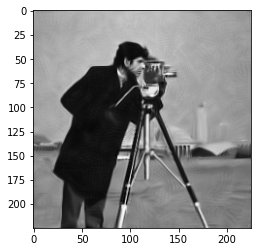

In [161]:
plt.imshow(WNNM_res_20,cmap='gray')
plt.show()

In [163]:
WNNM_res_20 = np.array(WNNM_res_20,dtype=np.int32)
np.max(WNNM_res_20)

251

In [106]:
mse_20,psnr_20 = MSE_and_PSNR(gt_img,WNNM_res_20)

In [107]:
print('MSE_20',mse_20)
print('psnr_20',psnr_20)

MSE_20 72.7927525874275
psnr_20 29.543917885080493


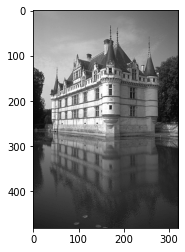

In [149]:
img = plt.imread('./BSD68/test003.png')
plt.imshow(img,cmap='gray')
plt.show()

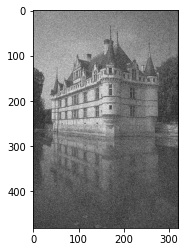

In [150]:
n_img = img + np.random.normal(0,25/255,img.shape)
plt.imshow(n_img,cmap='gray')
plt.show()

In [151]:
p_r = 3
delta = 0.1
c = 0.005
K = 3
threshold = 20
res = wnnm1(n_img,p_r,delta,c,K,25/255,threshold)

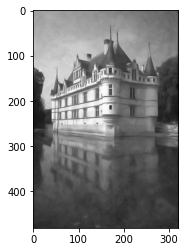

In [156]:
plt.imshow(res,cmap='gray')
plt.show()